In [1]:
suppressMessages({
  library(clusterProfiler)
  library(org.Hs.eg.db)
  library(DOSE)
  library(AnnotationHub)
  library('pheatmap')
  library("DOSE")
  library("enrichplot")
  library("ggupset")
  library("ggplot2")
  library("genekitr")
  library("dplyr")
  library("GOplot")
    
})

In [20]:
perform_gsea <- function(gene_down_in_up_loops, gene_back, OrgDb = org.Hs.eg.db, ont = "ALL", keyType = "ENTREZID", qvalueCutoff = 0.05, cutoff = 0.65, by = "p.adjust", select_fun = min, measure = "Wang") {
  # Perform GO enrichment analysis
  gsea_down_in_up_loops <- enrichGO(gene_down_in_up_loops$ENTREZID, 
                                    OrgDb = OrgDb, 
                                    # universe = gene_back$ENTREZID,                     
                                    ont = ont,
                                    keyType = keyType,                     
                                    qvalueCutoff = qvalueCutoff,
                                    readable = TRUE)
  
  # Check if enrichGO returned a valid result
  if (is.null(gsea_down_in_up_loops) || nrow(gsea_down_in_up_loops@result) == 0) {
    stop("enrichGO did not return any results.")
  }
  
  # Simplify the GO enrichment results
  simplified_gsea_down_in_up_loops <- simplify(gsea_down_in_up_loops, 
                                               cutoff = cutoff, 
                                               by = by, 
                                               select_fun = select_fun, 
                                               measure = measure)
  # simplified_gsea_down_in_up_loops = gsea_down_in_up_loops
  
    # Check if simplify returned a valid result
  if (is.null(simplified_gsea_down_in_up_loops) || nrow(simplified_gsea_down_in_up_loops@result) == 0) {
    stop("simplify did not return any results.")
  }
  
  # Generate pairwise term similarity matrix
  simplified_gsea_down_in_up_loops_pairs <- pairwise_termsim(simplified_gsea_down_in_up_loops)
  
  # Return the results
  return(list(
    gsea_results = gsea_down_in_up_loops,
    simplified_results = simplified_gsea_down_in_up_loops,
    pairwise_similarity = simplified_gsea_down_in_up_loops_pairs
  ))
}

create_treeplot_main <- function(simplified_gsea_down_in_up_loops_pairs, output_file, showCategory = 20, color = "p.adjust", fontsize = 4, geneClusterPanel = "dotplot", width = 14, height = 9, dpi = 700) {
  # Create the tree plot
  p1 <- treeplot(simplified_gsea_down_in_up_loops_pairs, 
                 showCategory = showCategory, 
                 color = color, 
                 offset.params = list(bar_tree = rel(2), tiplab = rel(1), hexpand = 0.6),
                 fontsize = fontsize, 
                 geneClusterPanel = geneClusterPanel)
  
  # Modify the size of the 7th layer
  p1$layers[[7]]$aes_params$size <- 4
  
  # Customize the plot theme
  p1 <- p1 + theme_void() +
    theme(
      text = element_text(family = "Helvetica"),
      plot.title = element_text(family = "Helvetica"),
      legend.text = element_text(family = "Helvetica"),
      plot.margin = unit(c(1, 1, 1, 1), "cm"),
      panel.background = element_rect(fill = "white", color = NA),
      plot.background = element_rect(fill = "white", color = NA)
    ) +
    coord_cartesian(clip = "off")
  
  # Save the plot to a file
  ggsave(output_file, plot = p1, width = width, height = height, device = 'pdf', dpi = dpi)
  
  # Return the plot object
  return(p1)
}

# 1. Up- and down- loops

In [24]:
cultural_loops_no_h3k27me3<- read.csv('/tank/projects/diana_hic/cultures_vs_postmortem/1_loops/loops_additional_files/cultural_loops_no_h3k27me3.csv')
cultural_loops_with_h3k27me3<- read.csv('/tank/projects/diana_hic/cultures_vs_postmortem/1_loops/loops_additional_files/cultural_loops_with_h3k27me3.csv')
cultural_loops_all<- read.csv('/tank/projects/diana_hic/cultures_vs_postmortem/1_loops/loops_additional_files/cultural_loops_all.csv')


neuronal_loops_no_h3k27me3<- read.csv('/tank/projects/diana_hic/cultures_vs_postmortem/1_loops/loops_additional_files/neuronal_loops_no_h3k27me3.csv')
neuronal_loops_with_h3k27me3<- read.csv('/tank/projects/diana_hic/cultures_vs_postmortem/1_loops/loops_additional_files/neuronal_loops_with_h3k27me3.csv')
neuronal_loops_all <- read.csv('/tank/projects/diana_hic/cultures_vs_postmortem/1_loops/loops_additional_files/neuronal_loops_all.csv')

TPM_protein_coding_PM <- read.csv('/tank/projects/diana_hic/cultures_vs_postmortem/1_loops/loops_additional_files/expressed_post_mortem.csv')
TPM_protein_coding_ipscDer <- read.csv('/tank/projects/diana_hic/cultures_vs_postmortem/1_loops/loops_additional_files/expressed_ipsc_derived.csv')

# cultural_loops_all<- read.csv('./loops_data/loops_clusters_data/cultural_loops_all.csv')
# neuronal_loops_all <- read.csv('./loops_data/loops_clusters_data/neuronal_loops_all.csv')

# TPM_protein_coding_PM <- read.csv('../4_additional_files/expressed_post_mortem.csv')
# TPM_protein_coding_ipscDer <- read.csv('../4_additional_files/expressed_ipsc_derived.csv')

In [26]:
gene_list <- cultural_loops_all$gene_name_anno
cultural_loops_all <- bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db)


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
“2.59% of input gene IDs are fail to map...”


In [28]:
gene_list <- TPM_protein_coding_ipscDer$name
TPM_protein_coding_ipscDer <- bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
“0.7% of input gene IDs are fail to map...”


In [30]:
gene_list <- neuronal_loops_no_h3k27me3$gene_name_anno
neuronal_loops_no_h3k27me3 <- bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db)

gene_list <- neuronal_loops_with_h3k27me3$gene_name_anno
neuronal_loops_with_h3k27me3 <- bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db)

gene_list <- neuronal_loops_all$gene_name_anno
neuronal_loops_all <- bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db)

gene_list <- TPM_protein_coding_PM$name
TPM_protein_coding_PM <- bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db)



'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
“2.72% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
“2.16% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
“3.93% of input gene IDs are fail to map...”
'select()' returned 1:many mapping between keys and columns

Warning message in bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
“1% of input gene IDs are fail to map...”


! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.



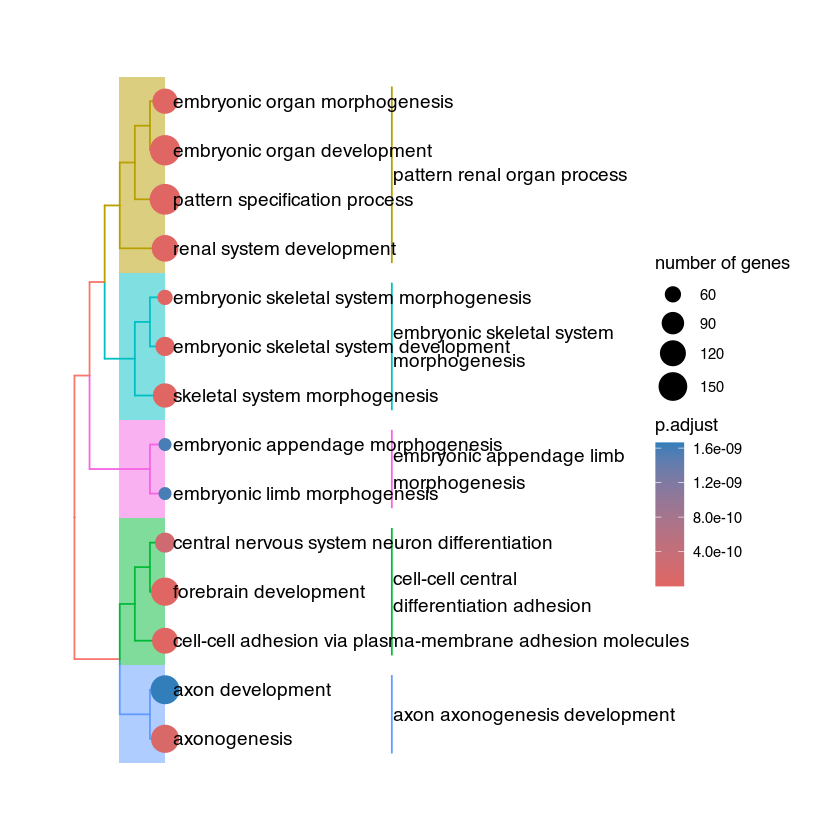

In [31]:
gsea_cultural_loops_all <- perform_gsea(cultural_loops_all, TPM_protein_coding_ipscDer, ont = "BP", cutoff = 0.8)
create_treeplot_main(gsea_cultural_loops_all$pairwise_similarity, "./loops_visualizations/loops_gsea_cultural_loops_no_h3k27me3.pdf", showCategory=14, height=5.2)


In [32]:
write.csv(tfs_down_polycomb, "./saved_data/fig4_k_case_cultural_loops_all.csv", row.names = FALSE)
write.csv(tfs_down_all, "./saved_data/fig4_k_background_genes_protein_coding.csv", row.names = FALSE)

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.



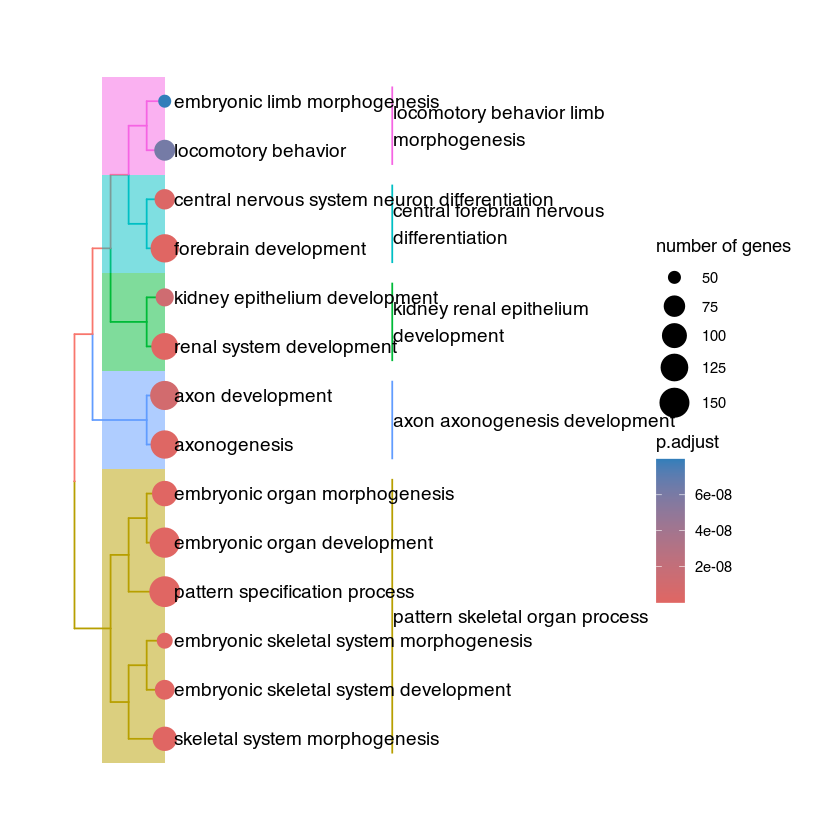

In [10]:
gsea_neuronal_loops_all <- perform_gsea(neuronal_loops_all, TPM_protein_coding_ipscDer, ont = "BP", cutoff = 0.8)
create_treeplot_main(gsea_cultural_loops_all$pairwise_similarity, "./loops_visualizations/loops_gsea_cultural_loops_no_h3k27me3.pdf", showCategory=14, height=5.2)


# TFs analysis


In [3]:
tfs_down_polycomb <- read.csv('./loops_data/loops_clusters_data/tfs_down_polycomb_gsea.csv')
tfs_down_all <- read.csv('./loops_data/loops_clusters_data/tfs_down_all_gsea.csv')

# tfs_down_polycomb <- read.csv('/tank/projects/diana_hic/cultures_vs_postmortem/1_loops/loops_additional_files/tfs_down_polycomb.csv')
# tfs_down_loops <- read.csv('/tank/projects/diana_hic/cultures_vs_postmortem/1_loops/loops_additional_files/tfs_down_loops.csv')
# tfs_down_all <- read.csv('/tank/projects/diana_hic/cultures_vs_postmortem/1_loops/loops_additional_files/down_tfs.csv')
# tfs_down_in_loops <- read.csv('/tank/projects/diana_hic/cultures_vs_postmortem/1_loops/loops_additional_files/tfs_down_in_loops.csv')
# tfs_down_not_polycomb <- read.csv('/tank/projects/diana_hic/cultures_vs_postmortem/1_loops/loops_additional_files/tfs_down_not_polycomb.csv')

In [4]:
gene_list <- tfs_down_polycomb$gene_name_anno
tfs_down_polycomb <- bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db)

gene_list <- tfs_down_all$gene_name_anno
tfs_down_all <- bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db)



'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Invaild edge matrix for <phylo>. A <tbl_df> is returned.

! # Inva

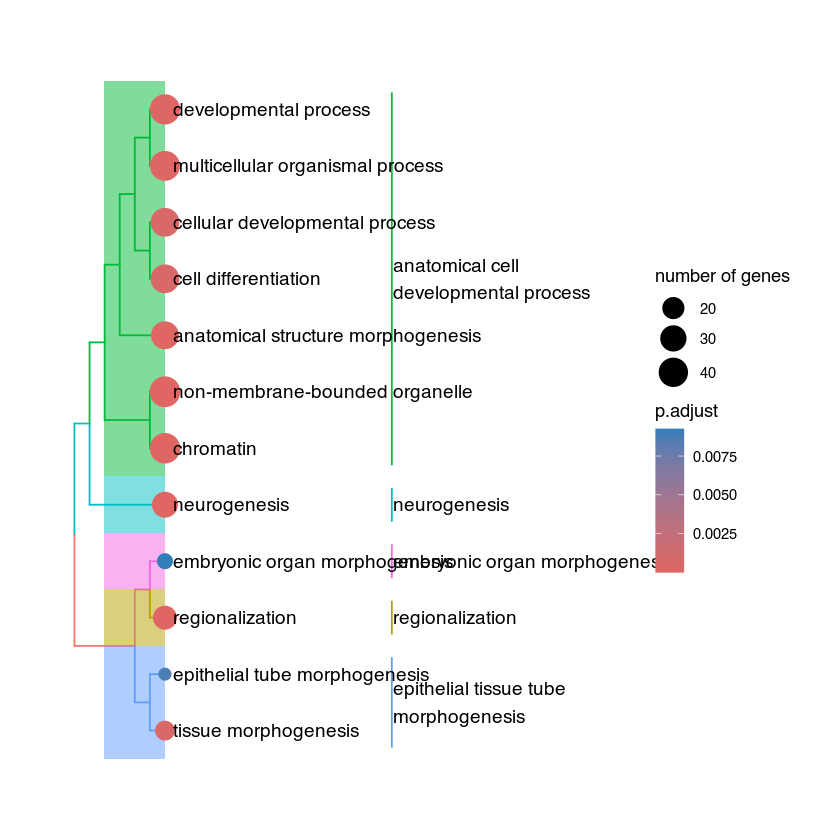

In [8]:
gsea_tfs_down_polycomb <- perform_gsea(tfs_down_polycomb, tfs_down_all, qvalueCutoff=0.01, cutoff = 0.75)
create_treeplot_main(gsea_tfs_down_polycomb$pairwise_similarity, "./loops_visualizations/gsea_tfs_down_polycomb2.pdf",height=4.3, showCategory=16)


In [13]:
write.csv(tfs_down_polycomb, "./saved_data/fig4_j_case_tfs_down_polycomb.csv", row.names = FALSE)
write.csv(tfs_down_all, "./saved_data/fig4_j_background_tfs_down_all.csv", row.names = FALSE)